# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor()])

# Create training set and define training dataloader
data_dir = 'CIFAR10'

dataset = torchvision.datasets.CIFAR10(data_dir, train=True, transform=transform,download=True)
train_data, valid_data = torch.utils.data.random_split(dataset,[40000,10000])

test_data = torchvision.datasets.CIFAR10(data_dir,train=False, transform=transform, download=True)
# Create test set and define test dataloader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=250, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=250)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=250)
# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

horse


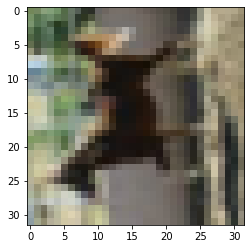

horse


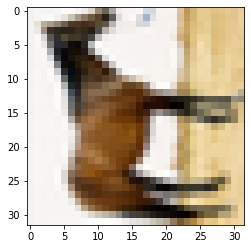

deer


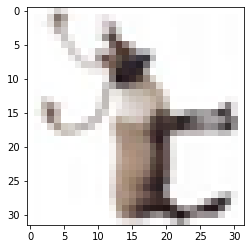

car


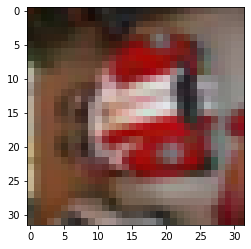

cat


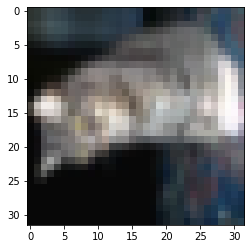

In [5]:
# Explore data

show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
## YOUR CODE HERE ##
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(3072,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,10)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x 

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
## YOUR CODE HERE ##

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
#torch.cuda.current_device()
#torch.cuda.get_device_name()

In [9]:
import time

In [10]:
## YOUR CODE HERE ##
epochs = 30
train_losses=[]
test_losses=[]

def train_test(epochs,model, trainloader, testloader, criterion, optimizer):
    for epoch in range(epochs):
        running_loss = 0
        #start = time.time()
        for images, labels in train_loader:


            optimizer.zero_grad()

            images, labels = images.to(device), labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:

            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)

                    logps = model.forward(images)
                    test_loss += criterion(logps, labels)

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()        

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/len(trainloader)}:.3f.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
      
   

In [11]:
train_test(epochs,model, train_loader, valid_loader,criterion, optimizer)

Epoch 1/30.. Train loss: 1.993368361145258:.3f.. Test loss: 1.823.. Test accuracy: 0.342
Epoch 2/30.. Train loss: 1.7953557133674622:.3f.. Test loss: 1.699.. Test accuracy: 0.392
Epoch 3/30.. Train loss: 1.7349327579140663:.3f.. Test loss: 1.673.. Test accuracy: 0.401
Epoch 4/30.. Train loss: 1.6923702113330363:.3f.. Test loss: 1.627.. Test accuracy: 0.417
Epoch 5/30.. Train loss: 1.6477071575820446:.3f.. Test loss: 1.574.. Test accuracy: 0.441
Epoch 6/30.. Train loss: 1.6237018458545207:.3f.. Test loss: 1.580.. Test accuracy: 0.434
Epoch 7/30.. Train loss: 1.5965828239917754:.3f.. Test loss: 1.535.. Test accuracy: 0.450
Epoch 8/30.. Train loss: 1.5657417207956315:.3f.. Test loss: 1.508.. Test accuracy: 0.462
Epoch 9/30.. Train loss: 1.558926197141409:.3f.. Test loss: 1.518.. Test accuracy: 0.458
Epoch 10/30.. Train loss: 1.531914772093296:.3f.. Test loss: 1.506.. Test accuracy: 0.469
Epoch 11/30.. Train loss: 1.5172988444566726:.3f.. Test loss: 1.478.. Test accuracy: 0.468
Epoch 12/30

Plot the training loss (and validation loss/accuracy, if recorded).

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

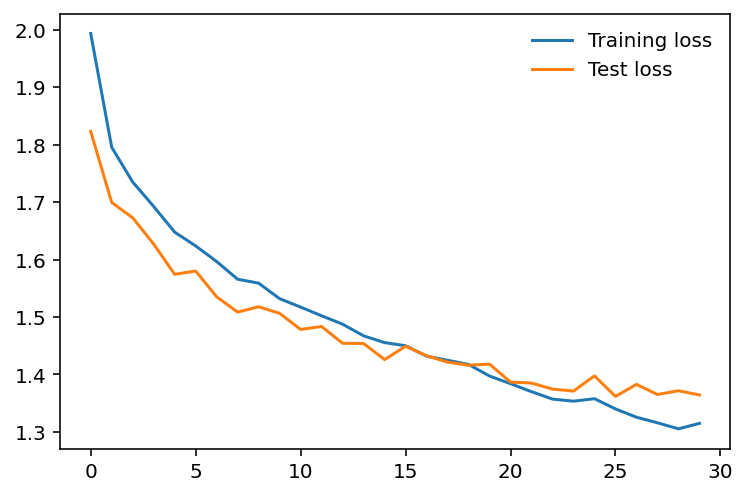

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
epochs = 1
train_losses=[]
test_losses=[]

train_test(epochs,model, train_loader, test_loader,criterion, optimizer)

Epoch 1/1.. Train loss: 1.2954389780759812:.3f.. Test loss: 1.360.. Test accuracy: 0.520


In [15]:
#plt.plot(train_losses, label='Training loss')
#plt.plot(test_losses, label='Test loss')
#plt.legend(frameon=False)

## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0091, -0.0055, -0.0139,  ..., -0.0199, -0.0131, -0.0100],
                      [-0.0122,  0.0024,  0.0067,  ...,  0.0187, -0.0014,  0.0207],
                      [ 0.0334,  0.0207,  0.0159,  ...,  0.0149,  0.0188, -0.0010],
                      ...,
                      [-0.0095, -0.0223, -0.0175,  ..., -0.0132, -0.0007, -0.0025],
                      [ 0.0328,  0.0072, -0.0263,  ...,  0.0476,  0.0312,  0.0186],
                      [-0.0147, -0.0180,  0.0014,  ..., -0.0154, -0.0198,  0.0107]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([-0.0125,  0.0044, -0.1304,  ...,  0.0088,  0.0462,  0.0101],
                     device='cuda:0')),
             ('fc2.weight',
              tensor([[ 0.0006,  0.0234, -0.0050,  ..., -0.0073, -0.0634, -0.0088],
                      [ 0.0109, -0.0307,  0.0753,  ...,  0.0253, -0.0349, -0.0325],
                      [ 0.0042, -0.0225,  0.0094,  ...,

In [17]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

I would recommend buying an object detection algorithim. This would most likely be a Convolutional network that would better analyze imagery than the created model. 

## Questions for Instructor 

How does data augmentation affect the train loss/accuracy of model?

Intuition for good batch size?

Is there a limit to how much data we want to use from the training set for validations? Would it be better to use the test set for smaller datasets? 
